### Data analysis for DIA-NN's result on SC-LPS dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
pandas2ri.activate()
numpy2ri.activate()

#### Check analysis time

In [2]:
report_dir = Path('../../reports/SC-LPS')
with open(report_dir/'diann_220'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-2].split(' ')[0][1:-1]
    total_minutes = int(time_str.split(':')[0]) + int(
        time_str.split(':')[-1]) / 60
    n = int(lines[-20].split(' ')[-2])
    t_mean = total_minutes / n
print(f'#runs: {n}, Minutes/Run: {t_mean:.2f}')

#runs: 160, Minutes/Run: 22.08


#### Check the report.parquet
1. #ids
2. miss rate

In [3]:
df_raw = pd.read_parquet(report_dir/'diann_220'/'report.parquet', engine='fastparquet')
n_pgs = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]['Protein.Group'].nunique()
n_prs = df_raw[df_raw['Global.Q.Value'] < 0.01]['Precursor.Id'].nunique()
print(f'Global n_prs: {n_prs}, Global n_pgs: {n_pgs}')

Global n_prs: 9258, Global n_pgs: 1596


In [4]:
df_raw['PG.Quantity'] = df_raw['PG.MaxLFQ'].values
df_raw = df_raw[~df_raw['Protein.Group'].str.contains(';')] # groups not in considering

# no local FDR filtering
df1 = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]
df1 = df1[['Protein.Group', 'Run', 'PG.Quantity']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1 = df1.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df1.isna().sum().sum() / df1.shape[0] / df1.shape[1]
print(f'Only Global FDR filtering, shape: {df1.shape}, miss: {miss:.2f}')

# global & local FDR filtering
df2 = df_raw[(df_raw['Global.PG.Q.Value'] < 0.01) & (df_raw['PG.Q.Value'] < 0.01)]
df2 = df2[['Protein.Group', 'Run', 'PG.Quantity']]
df2 = df2.drop_duplicates().reset_index(drop=True)
df2 = df2.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df2.isna().sum().sum() / df2.shape[0] / df2.shape[1]
print(f'Local & Global FDR filtering, shape: {df2.shape}, miss: {miss:.2f}')
df2.columns.name = None
df2.index.name = None
df_protein = df2
df_protein.copy()

Only Global FDR filtering, shape: (1544, 160), miss: 0.54
Local & Global FDR filtering, shape: (1544, 160), miss: 0.60


,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A2_1_4221,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A3_1_4222,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A4_1_4223,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A5_1_4224,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-A6_1_4225,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B1_1_4232,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B2_1_4233,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B3_1_4234,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B4_1_4235,20231202_Evo2_IO15_40SPD_scLF_LPS_20231202_DMSO_S1-B5_1_4236,...,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F11_1_4455,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F12_1_4456,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F7_1_4448,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-F8_1_4449,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G10_1_4466,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G11_1_4467,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G12_1_4468,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G7_1_4463,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G8_1_4464,20231207_Evo2_IO15_40SPD_scLF_LPS_20231207_LPS_200ng_S1-G9_1_4465
A0A0C4DH25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A2R8Y7D0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0FGR8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0FGR9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1IGU5,13846.629883,14660.566406,9583.099609,NaN,17580.03125,10072.605469,14757.850586,13861.345703,15884.830078,11283.567383,...,NaN,2126.907715,NaN,5603.327148,NaN,NaN,NaN,2158.590332,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y678,NaN,NaN,NaN,NaN,NaN,NaN,2134.301025,NaN,NaN,NaN,...,1957.723267,NaN,NaN,NaN,1291.178589,NaN,NaN,2123.554688,NaN,1461.927734
Q9Y6E2,NaN,NaN,2723.825439,NaN,NaN,5132.481934,5416.162109,3472.176270,NaN,4251.278809,...,NaN,NaN,4081.768555,2243.155029,NaN,NaN,NaN,NaN,NaN,2082.804932
Q9Y6M1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y6N5,NaN,838.008301,NaN,NaN,NaN,NaN,2477.121338,NaN,NaN,871.291443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1114.316406


#### Convert to cell*protein matrix

In [5]:
df_meta = pd.read_excel(report_dir/'meta'/'meta_batch.xlsx', sheet_name='ExperimentalDesign')
df_meta['sample_id'] = 'sample_' + df_meta['ID'].str.split('_').str[-1]
df_meta['batch_id'] = df_meta['Batch'].astype(str)
df_meta['treat_id'] = df_meta['Treatment']
df_meta = df_meta[['sample_id', 'batch_id', 'treat_id']]

df_protein.columns = 'sample_' + df_protein.columns.str.split('_').str[-1]
df_sample = df_protein.T
df_sample = df_sample.merge(df_meta, left_index=True, right_on='sample_id')
df_sample = df_sample.reset_index(drop=True)
df_sample = df_sample[df_sample.columns[::-1]]
df_sample.copy()

,treat_id,batch_id,sample_id,Q9Y6R7,Q9Y6N5,Q9Y6M1,Q9Y6E2,Q9Y678,Q9Y646,Q9Y623,...,O00115,B9A064,A8K2U0,A4FU69,A4D1P6,A1IGU5,A0FGR9,A0FGR8,A0A2R8Y7D0,A0A0C4DH25
0,DMSO,1,sample_4221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13846.629883,NaN,NaN,NaN,NaN
1,DMSO,1,sample_4222,NaN,838.008301,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14660.566406,NaN,NaN,NaN,NaN
2,DMSO,1,sample_4223,NaN,NaN,NaN,2723.825439,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,9583.099609,NaN,NaN,NaN,NaN
3,DMSO,1,sample_4224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3989.422607,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DMSO,1,sample_4225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4462.161621,NaN,NaN,17580.031250,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LPS,2,sample_4468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LPS,2,sample_4463,NaN,NaN,NaN,NaN,2123.554688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2158.590332,NaN,NaN,NaN,NaN
155,LPS,2,sample_4464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9510.413086,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Preprocess
1. drop the high-missingness proteins
2. impute
3. normalization by SCnorm
4. log-transformation
5. batch-correction by limma

##### drop

In [6]:
cut_miss = 0.7
cols_pg = [col for col in df_sample.columns if not col.endswith('_id')]
cols_id = [col for col in df_sample.columns if col.endswith('_id')]
miss_ratio = df_sample[cols_pg].isna().mean()
cols_pg = miss_ratio[miss_ratio < cut_miss].index.tolist()
df_drop = df_sample[cols_id + cols_pg]
df_drop.copy()

,treat_id,batch_id,sample_id,Q9Y6N5,Q9Y6E2,Q9Y5S9,Q9Y5L4,Q9Y5B9,Q9Y4L1,Q9Y490,...,O00442,O00425,O00299,O00232,O00231,O00182,O00160,O00148,A8K2U0,A1IGU5
0,DMSO,1,sample_4221,NaN,NaN,NaN,9714.819336,2776.497803,1962.861206,5601.357422,...,5625.589355,1095.457764,20225.738281,NaN,1614.275513,NaN,3549.506104,NaN,NaN,13846.629883
1,DMSO,1,sample_4222,838.008301,NaN,2795.443115,8625.444336,5397.554199,4769.425293,6625.088867,...,5999.290039,2209.948242,42668.261719,3252.185059,2537.832275,4515.610352,2058.127686,8057.888184,NaN,14660.566406
2,DMSO,1,sample_4223,NaN,2723.825439,3826.832764,NaN,4932.677734,2332.209717,4738.848145,...,4007.650879,2441.895508,26409.513672,1616.127319,1428.996948,3187.824463,NaN,6281.426758,NaN,9583.099609
3,DMSO,1,sample_4224,NaN,NaN,3940.539307,5620.639648,3139.971680,2751.096191,4163.947266,...,4616.153320,1787.978149,22305.462891,1898.829712,NaN,NaN,730.622925,4526.407227,3989.422607,NaN
4,DMSO,1,sample_4225,NaN,NaN,4722.480469,4586.567871,3397.960938,NaN,3743.964600,...,NaN,2546.376953,17080.324219,NaN,NaN,NaN,2062.066406,3665.025879,4462.161621,17580.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,NaN,NaN,NaN,NaN,NaN,2378.876221,2778.622314,...,NaN,NaN,17952.441406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,LPS,2,sample_4468,NaN,NaN,NaN,NaN,NaN,NaN,2514.916992,...,NaN,NaN,15112.566406,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,LPS,2,sample_4463,NaN,NaN,NaN,NaN,1900.237793,1892.553467,3684.036377,...,NaN,1611.734009,17674.328125,NaN,NaN,1969.294067,1511.410156,NaN,NaN,2158.590332
155,LPS,2,sample_4464,NaN,NaN,NaN,NaN,NaN,2363.762207,4037.529297,...,NaN,NaN,26265.121094,NaN,982.031982,NaN,NaN,NaN,9510.413086,NaN


##### impute

In [7]:
def impute(df):
    cols_X = df.columns[3:]
    protein_group = cols_X.to_list()
    sample_names = df['sample_id'].to_list()

    df_protein = df[cols_X].values.astype(float).T
    ro.globalenv["data_counts"] = df_protein
    ro.globalenv["protein_group"] = ro.StrVector(protein_group)
    ro.globalenv["sample_names"] = ro.StrVector(sample_names)

    r_script = """
        suppressPackageStartupMessages({
            library(MSnbase)
        })

        data.mat <- as.matrix(data_counts)
        data.mat[is.nan(data.mat)] <- NA
        rownames(data.mat) <- protein_group
        colnames(data.mat) <- sample_names
        msnset <- MSnSet(exprs = data.mat)
        msnset.imputed <- impute(msnset, method = "MinProb")
        data.imputed <- exprs(msnset.imputed)
        """
    ro.r(r_script)

    imputed_r = ro.r("data.imputed")
    imputed_np = np.array(imputed_r)
    imputed_np[imputed_np < 0] = 0
    df[cols_X] = imputed_np.T
    return df
df_impute = impute(df_drop)
df_impute.copy()

R[write to console]: Loading required namespace: imputeLCMD

R[write to console]: Imputing along margin 2 (samples/columns).



[1] 4710.327


C:\Users\84118\AppData\Local\Temp\ipykernel_76912\3944773784.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols_X] = imputed_np.T


,treat_id,batch_id,sample_id,Q9Y6N5,Q9Y6E2,Q9Y5S9,Q9Y5L4,Q9Y5B9,Q9Y4L1,Q9Y490,...,O00442,O00425,O00299,O00232,O00231,O00182,O00160,O00148,A8K2U0,A1IGU5
0,DMSO,1,sample_4221,5919.768770,5880.945981,0.000000,9714.819336,2776.497803,1962.861206,5601.357422,...,5625.589355,1095.457764,20225.738281,3185.562061,1614.275513,0.000000,3549.506104,7719.901811,0.000000,13846.629883
1,DMSO,1,sample_4222,838.008301,0.000000,2795.443115,8625.444336,5397.554199,4769.425293,6625.088867,...,5999.290039,2209.948242,42668.261719,3252.185059,2537.832275,4515.610352,2058.127686,8057.888184,0.000000,14660.566406
2,DMSO,1,sample_4223,1256.625740,2723.825439,3826.832764,0.000000,4932.677734,2332.209717,4738.848145,...,4007.650879,2441.895508,26409.513672,1616.127319,1428.996948,3187.824463,0.000000,6281.426758,7774.575955,9583.099609
3,DMSO,1,sample_4224,0.000000,1216.438410,3940.539307,5620.639648,3139.971680,2751.096191,4163.947266,...,4616.153320,1787.978149,22305.462891,1898.829712,0.000000,10555.454717,730.622925,4526.407227,3989.422607,8839.075502
4,DMSO,1,sample_4225,1624.207342,0.000000,4722.480469,4586.567871,3397.960938,686.280622,3743.964600,...,4617.526393,2546.376953,17080.324219,3867.119685,0.000000,0.000000,2062.066406,3665.025879,4462.161621,17580.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,0.000000,281.076051,3963.936589,808.319389,0.000000,2378.876221,2778.622314,...,4703.896070,2563.662462,17952.441406,0.000000,5813.133172,0.000000,0.000000,6304.162724,10006.126701,0.000000
153,LPS,2,sample_4468,0.000000,0.000000,0.000000,0.000000,0.000000,3395.312118,2514.916992,...,672.412679,0.000000,15112.566406,730.427394,2983.169272,0.000000,10374.044415,0.000000,9975.875623,0.000000
154,LPS,2,sample_4463,4964.283519,0.000000,0.000000,0.000000,1900.237793,1892.553467,3684.036377,...,8938.809462,1611.734009,17674.328125,0.000000,7439.962948,1969.294067,1511.410156,447.523152,0.000000,2158.590332
155,LPS,2,sample_4464,0.000000,0.000000,5305.241069,0.000000,0.000000,2363.762207,4037.529297,...,2880.421632,2730.098661,26265.121094,0.000000,982.031982,7114.557592,1798.834298,0.000000,9510.413086,1644.588009


##### normalize by SCnorm

In [8]:
def norm_by_scnorm(df):
    # names
    cols_X = df.columns[~df.columns.str.endswith('_id')]
    cell_names = df['sample_id'].to_list()
    protein_group = cols_X.to_list()
    meta = df[['batch_id', 'treat_id']].copy()

    # R input
    ro.globalenv["data_counts"] = df[cols_X].values.T
    ro.globalenv["protein_group"] = ro.StrVector(protein_group)
    ro.globalenv["meta"] = meta
    ro.globalenv["cell_names"] = ro.StrVector(cell_names)

    # R script
    r_script = """
        suppressPackageStartupMessages({
            library(SingleCellExperiment)
            library(scran)
            library(SCnorm)
        })

        data.counts <- as.matrix(data_counts)
        rownames(data.counts) <- protein_group
        colnames(data.counts) <- cell_names

        data.sc <- SingleCellExperiment(
            assays = list("counts" = data.counts),
            colData = data.frame(BatchInfo = meta$batch_id)
        )

        Conditions <- quickCluster(data.sc, method = "hclust", min.size = 10)
        data.sc.norm <- SCnorm(Data = data.sc, Conditions = Conditions, NCores = 1)
        data.sc.norm.data <- normcounts(data.sc.norm)
        """
    ro.r(r_script)
    norm_counts_r = ro.r("data.sc.norm.data")
    norm_counts = np.array(norm_counts_r)
    df[cols_X] = norm_counts.T
    return df
df_norm = norm_by_scnorm(df_impute)
df_norm.copy()

R[write to console]: Setting up parallel computation using 1 cores

R[write to console]: Gene filter is applied within each condition.

R[write to console]: 0 genes in condition 1 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 2 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 5 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 3 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 63 genes in condition 6 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: 0 genes in condition 4 will not be included in the normalization due to 
             the specified filter criteria.

R[write to console]: A list o

,treat_id,batch_id,sample_id,Q9Y6N5,Q9Y6E2,Q9Y5S9,Q9Y5L4,Q9Y5B9,Q9Y4L1,Q9Y490,...,O00442,O00425,O00299,O00232,O00231,O00182,O00160,O00148,A8K2U0,A1IGU5
0,DMSO,1,sample_4221,6059.00,5834.20,0.00,8592.06,2513.90,1833.59,5071.58,...,5580.88,1121.22,18789.10,3260.48,1652.24,0.00,3632.99,6989.76,0.00,13418.10
1,DMSO,1,sample_4222,936.91,0.00,2719.70,7437.12,5251.32,5332.30,6445.59,...,5836.75,2470.76,36967.31,3636.00,2837.34,5048.53,2301.02,7839.57,0.00,12640.78
2,DMSO,1,sample_4223,1613.02,2582.93,3628.89,0.00,4677.53,2993.66,4898.02,...,3800.35,2875.73,22504.99,1903.25,1682.88,3754.19,0.00,6492.41,6276.02,7735.95
3,DMSO,1,sample_4224,0.00,1301.57,4216.32,5707.36,3264.09,2950.56,4328.55,...,4939.21,1973.79,22348.88,2096.16,0.00,11652.42,806.55,4705.33,4050.97,9238.40
4,DMSO,1,sample_4225,1919.16,0.00,5408.51,5835.84,4426.10,922.29,4876.80,...,5288.31,3008.79,18317.68,4569.37,0.00,0.00,2436.53,4773.98,5677.55,19667.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,0.00,299.64,5224.43,1568.53,0.00,2867.07,3751.58,...,5014.65,1972.36,35719.30,0.00,4472.35,0.00,0.00,8522.35,15717.55,0.00
153,LPS,2,sample_4468,0.00,0.00,0.00,0.00,0.00,3458.46,3366.06,...,914.73,0.00,25412.89,717.09,2928.71,0.00,10184.64,0.00,15670.03,0.00
154,LPS,2,sample_4463,5729.25,0.00,0.00,0.00,2855.14,2532.23,5535.33,...,11584.72,1860.09,28621.32,0.00,8586.42,2272.75,1744.31,579.99,0.00,3532.50
155,LPS,2,sample_4464,0.00,0.00,5157.68,0.00,0.00,2061.99,3933.32,...,2806.08,2381.55,40070.82,0.00,856.66,6206.26,1572.42,0.00,13816.08,2132.89


##### log

In [9]:
df_log = df_norm.copy()
df_log[cols_pg] = np.log2(df_log[cols_pg] + 1.)
df_log.copy()

,treat_id,batch_id,sample_id,Q9Y6N5,Q9Y6E2,Q9Y5S9,Q9Y5L4,Q9Y5B9,Q9Y4L1,Q9Y490,...,O00442,O00425,O00299,O00232,O00231,O00182,O00160,O00148,A8K2U0,A1IGU5
0,DMSO,1,sample_4221,12.565102,12.510566,0.000000,13.068956,11.296285,10.841242,12.308504,...,12.446535,10.132140,14.197685,11.671311,10.691080,0.000000,11.827339,12.771234,0.000000,13.712000
1,DMSO,1,sample_4222,9.873306,0.000000,11.409762,12.860722,12.358739,12.380813,12.654321,...,12.511197,11.271323,15.174001,11.828533,11.470832,12.301933,11.168685,12.936743,0.000000,13.625912
2,DMSO,1,sample_4223,10.656443,11.335351,11.825710,0.000000,12.191840,11.548176,12.258277,...,11.892296,11.490214,14.458021,10.895007,10.717574,11.874670,0.000000,12.664761,12.615864,12.917549
3,DMSO,1,sample_4224,0.000000,10.347145,12.042111,12.478861,11.672907,11.527262,12.080001,...,12.270357,10.947484,14.447979,11.034221,0.000000,13.508466,9.657408,12.200387,11.984408,13.173583
4,DMSO,1,sample_4225,10.907011,0.000000,12.401282,12.510972,12.112146,9.850640,12.252015,...,12.368864,11.555447,14.161028,12.158095,0.000000,0.000000,11.251204,12.221279,12.471307,14.263566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,0.000000,8.231893,12.351334,10.616117,0.000000,11.485865,11.873667,...,12.292221,10.946438,15.124457,0.000000,12.127140,0.000000,0.000000,13.057205,13.940181,0.000000
153,LPS,2,sample_4468,0.000000,0.000000,0.000000,0.000000,0.000000,11.756331,11.717274,...,9.838778,0.000000,14.633330,9.488021,11.516542,0.000000,13.314249,0.000000,13.935812,0.000000
154,LPS,2,sample_4463,12.484382,0.000000,0.000000,0.000000,11.479851,11.306762,12.434714,...,13.500060,10.861932,14.804853,0.000000,13.068009,11.150858,10.769268,9.182370,0.000000,11.786882
155,LPS,2,sample_4464,0.000000,0.000000,12.332786,0.000000,0.000000,11.010521,11.941899,...,11.454854,11.218291,15.290300,0.000000,9.744262,12.599741,10.619688,0.000000,13.754165,11.059270


C:\Users\84118\AppData\Local\Temp\ipykernel_76912\3256150743.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,
C:\Users\84118\AppData\Local\Temp\ipykernel_76912\3256150743.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,


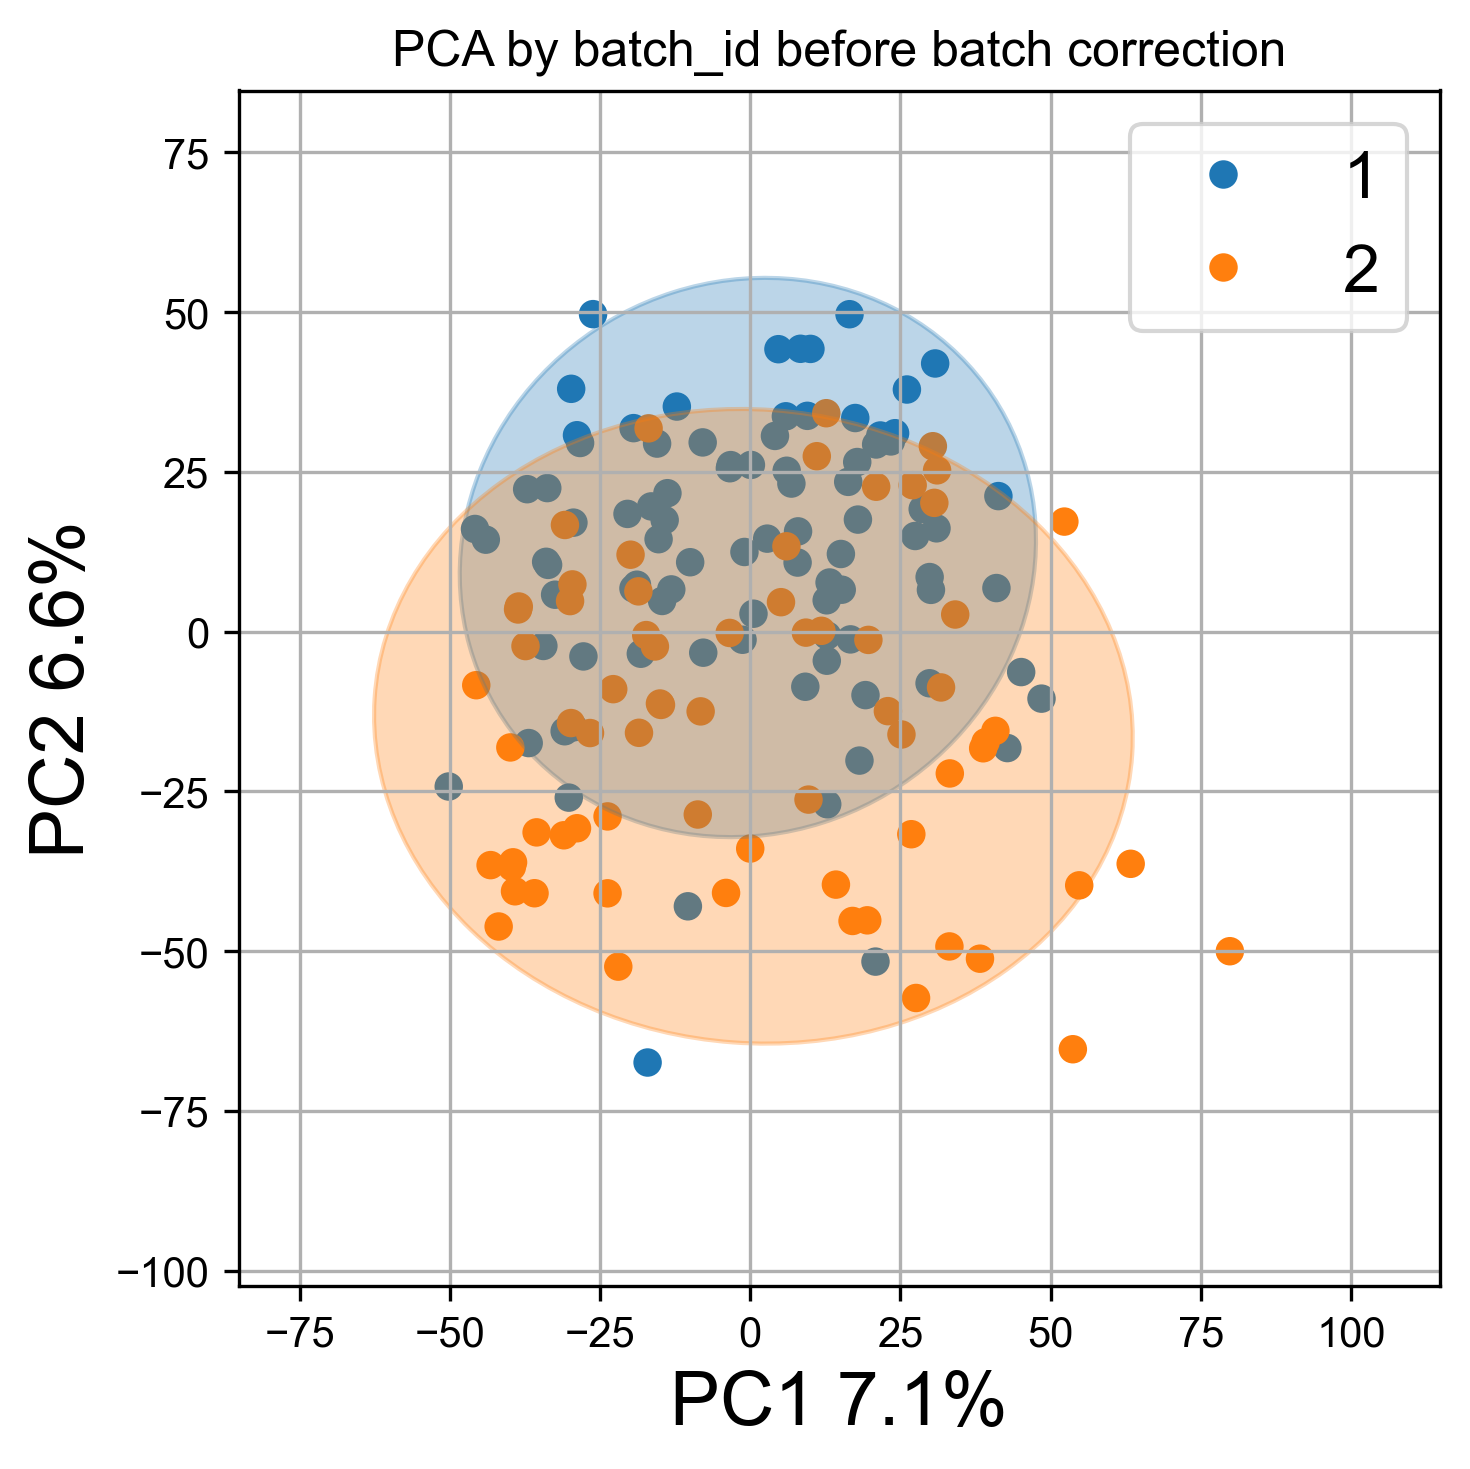

In [10]:
# pca by 'batch_id' before batch-correction
cols_X = df_log.columns[~df_log.columns.str.endswith('_id')]
data = df_log[cols_X].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'batch_id': df_log['batch_id'].values
})
plt.figure(figsize=(5, 5))
batch_colors = {df_plot['batch_id'].unique()[0]: '#1f77b4',
                df_plot['batch_id'].unique()[1]: '#ff7f0e'}
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='batch_id', data=df_plot, palette=batch_colors, s=40,
    edgecolor=None
)
# ellipse
for batch, color in batch_colors.items():
    batch_data = df_plot[df_plot['batch_id'] == batch]
    if len(batch_data) > 1:
        cov = np.cov(batch_data[['PC1', 'PC2']].T)
        mean = batch_data[['PC1', 'PC2']].mean().values
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues) * 2  # 95% 置信区间
        ellipse = Ellipse(mean, width, height, angle, color=color,
                          alpha=0.3)
        ax.add_patch(ellipse)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(df_plot['PC1'].min() - 35, df_plot['PC1'].max() + 35)
ax.set_ylim(df_plot['PC2'].min() - 35, df_plot['PC2'].max() + 35)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='upper right')
plt.title('PCA by batch_id before batch correction')
plt.tight_layout()
plt.show()

In [11]:
# batch correction by limma
def remove_batch_limma(df):
    # names
    cols_X = df.columns[~df.columns.str.endswith('_id')]
    meta = df[['batch_id', 'treat_id']].copy()

    # R input
    ro.globalenv["data.sc.log"] = df[cols_X].values.T
    ro.globalenv["meta"] = meta

    # R script
    r_script = """
            suppressPackageStartupMessages({
                library(SingleCellExperiment)
                library(scran)
                library(limma)
            })
            expr_matrix <- data.sc.log
            batch <- meta$batch_id
            group <- meta$treat_id
            design <- model.matrix(~group)
            expr_corrected <- removeBatchEffect(
              expr_matrix,
              batch = batch,
              design = design
            )
            """
    ro.r(r_script)
    x = ro.r("expr_corrected")
    x = np.array(x)
    df[cols_X] = x.T
    return df
df_corr = remove_batch_limma(df_log)
df_corr.copy()

,treat_id,batch_id,sample_id,Q9Y6N5,Q9Y6E2,Q9Y5S9,Q9Y5L4,Q9Y5B9,Q9Y4L1,Q9Y490,...,O00442,O00425,O00299,O00232,O00231,O00182,O00160,O00148,A8K2U0,A1IGU5
0,DMSO,1,sample_4221,12.209059,12.722918,-1.393724,12.403277,10.029150,10.546139,12.169190,...,10.997584,10.930791,14.189702,11.820311,10.225888,-0.144432,10.742740,11.164097,0.201436,12.104584
1,DMSO,1,sample_4222,9.517262,0.212352,10.016038,12.195043,11.091604,12.085710,12.515007,...,11.062245,12.069974,15.166018,11.977533,11.005639,12.157501,10.084085,11.329606,0.201436,12.018496
2,DMSO,1,sample_4223,10.300399,11.547703,10.431986,-0.665679,10.924704,11.253074,12.118964,...,10.443344,12.288865,14.450038,11.044007,10.252381,11.730238,-1.084599,11.057624,12.817300,11.310133
3,DMSO,1,sample_4224,-0.356043,10.559497,10.648387,11.813181,10.405772,11.232159,11.940688,...,10.821405,11.746135,14.439996,11.183221,-0.465193,13.364033,8.572809,10.593250,12.185844,11.566167
4,DMSO,1,sample_4225,10.550968,0.212352,11.007558,11.845293,10.845011,9.555537,12.112701,...,10.919912,12.354098,14.153045,12.307095,-0.465193,-0.144432,10.166605,10.614142,12.672743,12.656150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,LPS,2,sample_4467,0.356043,8.019541,13.745058,11.281796,1.267135,11.780967,12.012981,...,13.741173,10.147787,15.132440,-0.149000,12.592333,0.144432,1.084599,14.664342,13.738744,1.607416
153,LPS,2,sample_4468,0.356043,-0.212352,1.393724,0.665679,1.267135,12.051434,11.856587,...,11.287730,-0.798651,14.641313,9.339021,11.981735,0.144432,14.398848,1.607137,13.734376,1.607416
154,LPS,2,sample_4463,12.840426,-0.212352,1.393724,0.665679,12.746986,11.601865,12.574028,...,14.949012,10.063281,14.812836,-0.149000,13.533202,11.295290,11.853867,10.789506,-0.201436,13.394299
155,LPS,2,sample_4464,0.356043,-0.212352,13.726510,0.665679,1.267135,11.305624,12.081212,...,12.903806,10.419640,15.298284,-0.149000,10.209455,12.744173,11.704287,1.607137,13.552729,12.666687


C:\Users\84118\AppData\Local\Temp\ipykernel_76912\1975689082.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,
C:\Users\84118\AppData\Local\Temp\ipykernel_76912\1975689082.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,


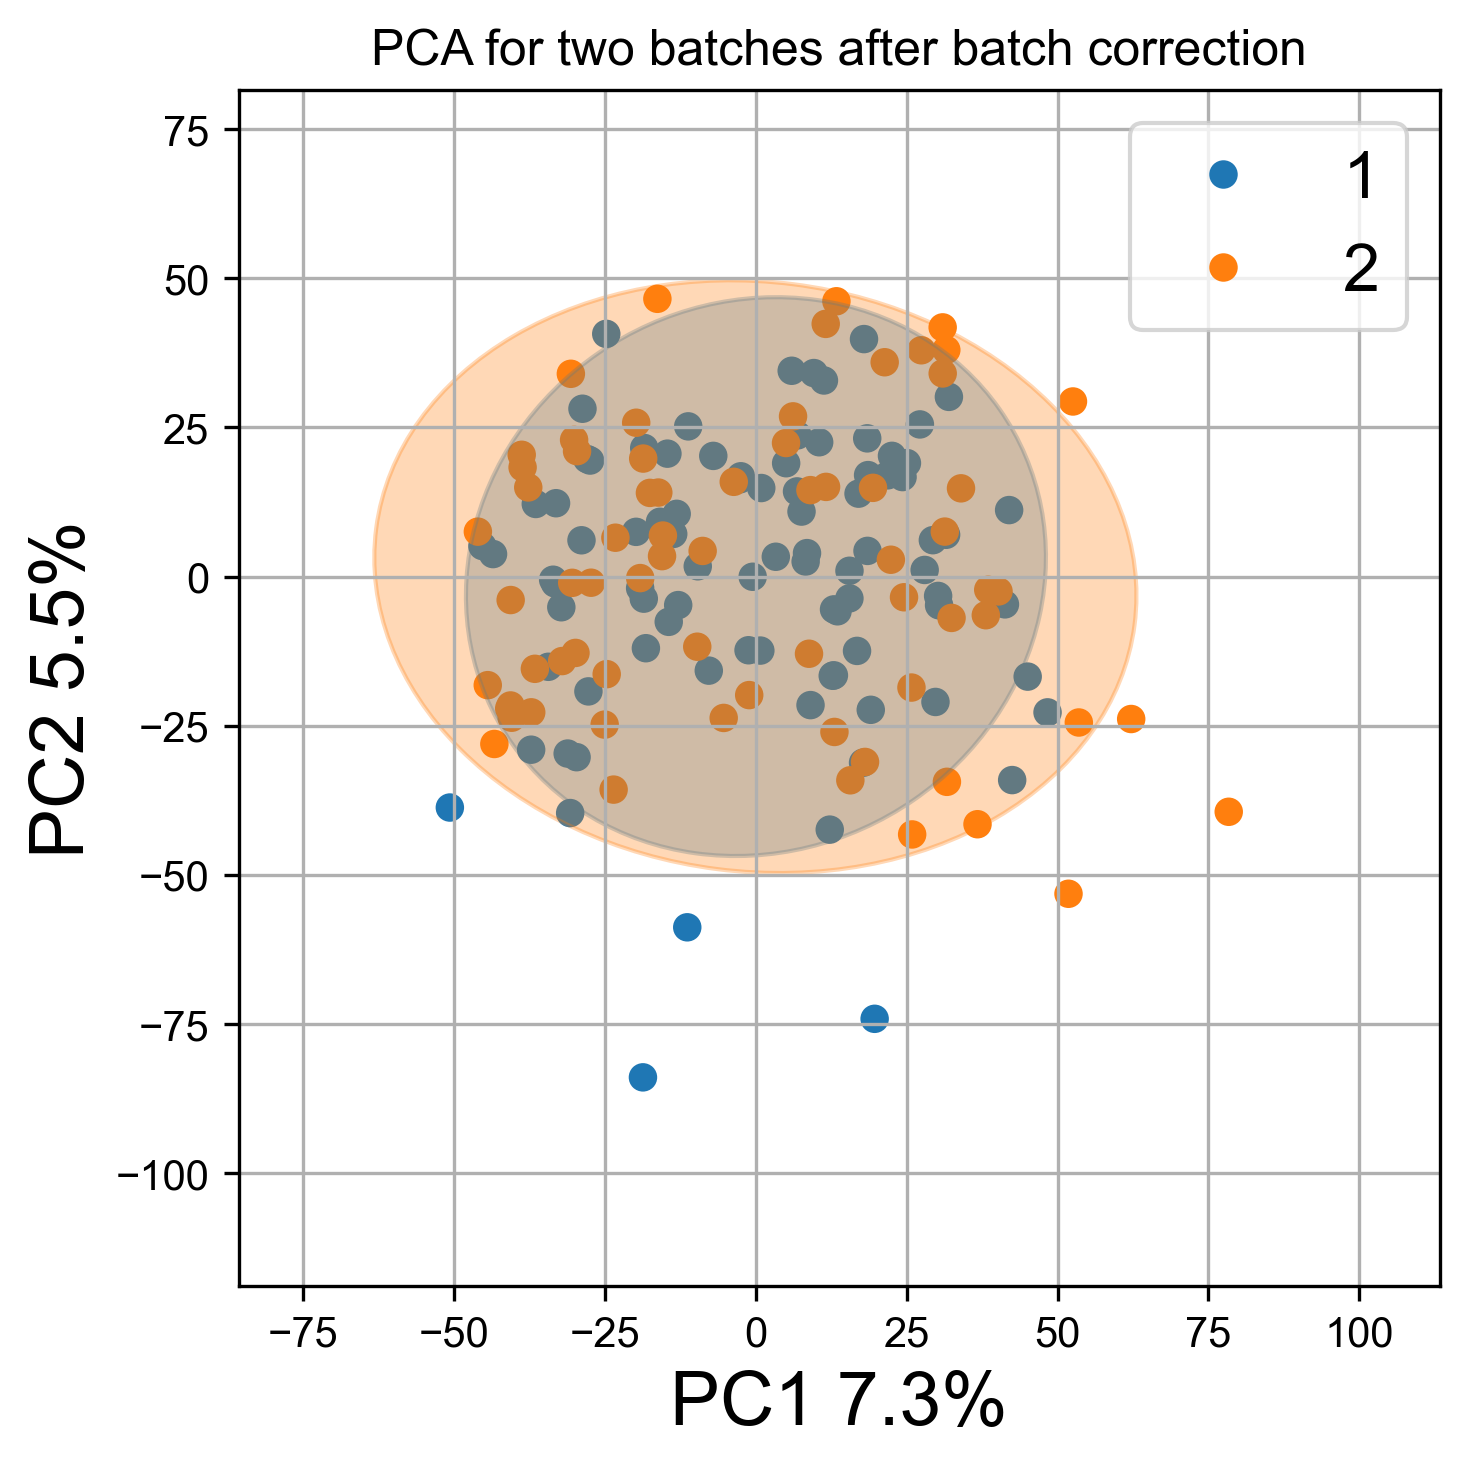

In [12]:
# pca by 'batch_id' after batch-correction
cols_X = df_corr.columns[~df_corr.columns.str.endswith('_id')]
data = df_corr[cols_X].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'batch_id': df_corr['batch_id'].values
})
plt.figure(figsize=(5, 5))
batch_colors = {df_plot['batch_id'].unique()[0]: '#1f77b4',
                df_plot['batch_id'].unique()[1]: '#ff7f0e'}
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='batch_id', data=df_plot, palette=batch_colors, s=40,
    edgecolor=None
)
# ellipse
for batch, color in batch_colors.items():
    batch_data = df_plot[df_plot['batch_id'] == batch]
    if len(batch_data) > 1:
        cov = np.cov(batch_data[['PC1', 'PC2']].T)
        mean = batch_data[['PC1', 'PC2']].mean().values
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues) * 2  # 95% 置信区间
        ellipse = Ellipse(mean, width, height, angle, color=color,
                          alpha=0.3)
        ax.add_patch(ellipse)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(df_plot['PC1'].min() - 35, df_plot['PC1'].max() + 35)
ax.set_ylim(df_plot['PC2'].min() - 35, df_plot['PC2'].max() + 35)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='upper right')
plt.title('PCA for two batches after batch correction')
plt.tight_layout()
plt.show()

#### PCA

C:\Users\84118\AppData\Local\Temp\ipykernel_76912\2922444190.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,
C:\Users\84118\AppData\Local\Temp\ipykernel_76912\2922444190.py:29: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(mean, width, height, angle, color=color,


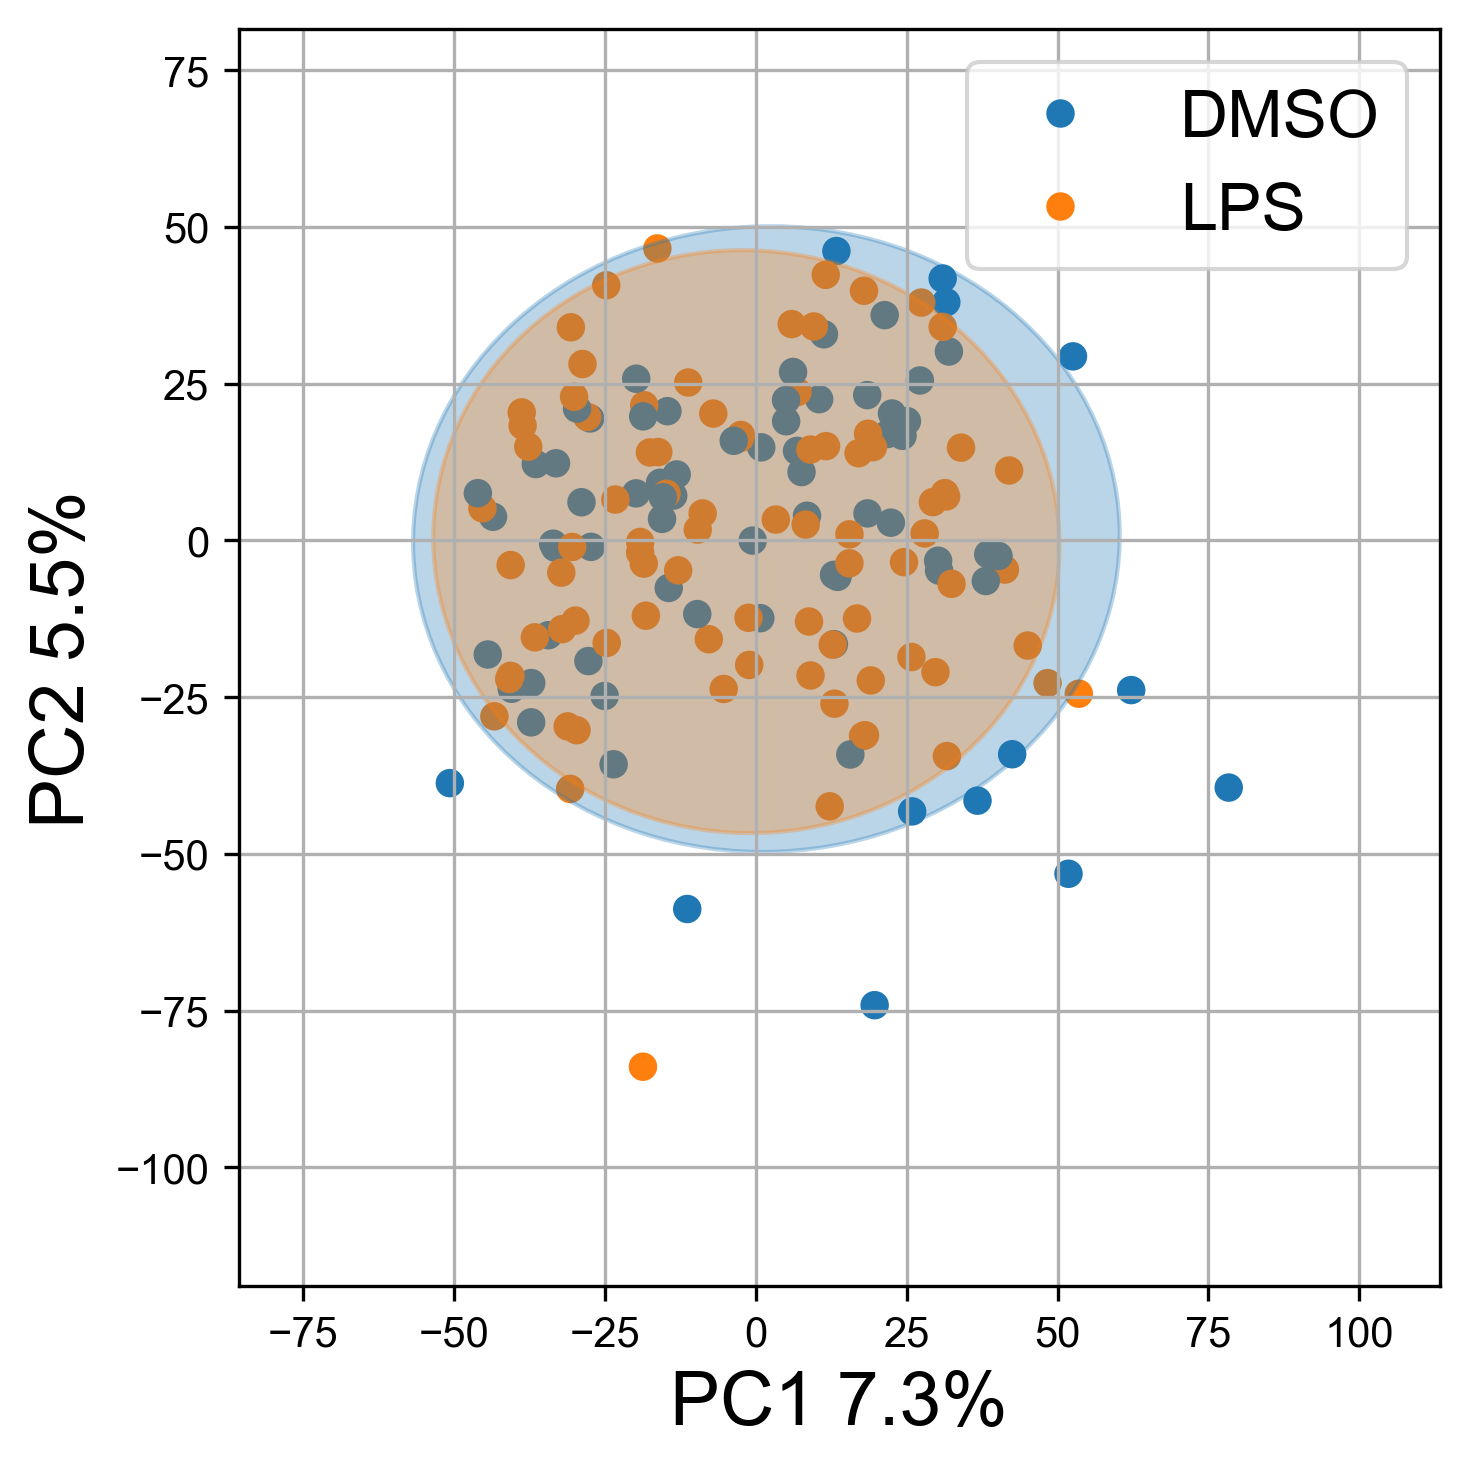

In [13]:
# pca by 'treat_id'
cols_X = df_corr.columns[~df_corr.columns.str.endswith('_id')]
data = df_corr[cols_X].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'treat_id': df_corr['treat_id'].values
})
plt.figure(figsize=(5, 5))
batch_colors = {df_plot['treat_id'].unique()[0]: '#1f77b4',
                df_plot['treat_id'].unique()[1]: '#ff7f0e'}
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='treat_id', data=df_plot, palette=batch_colors, s=40,
    edgecolor=None
)
# ellipse
for batch, color in batch_colors.items():
    batch_data = df_plot[df_plot['treat_id'] == batch]
    if len(batch_data) > 1:
        cov = np.cov(batch_data[['PC1', 'PC2']].T)
        mean = batch_data[['PC1', 'PC2']].mean().values
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigenvalues) * 2  # 95% 置信区间
        ellipse = Ellipse(mean, width, height, angle, color=color,
                          alpha=0.3)
        ax.add_patch(ellipse)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(df_plot['PC1'].min() - 35, df_plot['PC1'].max() + 35)
ax.set_ylim(df_plot['PC2'].min() - 35, df_plot['PC2'].max() + 35)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='upper right')
plt.tight_layout()
plt.show()

#### Differential Expression
- LPS (treat group) vs. DMSO (control group)
- DEP calculation
- Volcano plot

In [14]:
# calculating: p, adj p, fc
def cal_fc_pvalue_limma(df):
    cols_X = df.columns[~df.columns.str.endswith('_id')]
    expr = df[cols_X].values.T
    meta = pd.DataFrame(
        {'Treatment': df['treat_id'].values})

    r_expr = ro.conversion.py2rpy(expr)
    r_meta = ro.conversion.py2rpy(meta)
    ro.globalenv['expr_matrix'] = r_expr
    ro.globalenv['meta'] = r_meta
    ro.globalenv['protein'] = ro.StrVector(cols_X.to_list())

    r_script = '''
            library(limma)
            rownames(expr_matrix) <- protein
            design <- model.matrix(~ Treatment, data = meta)
            fit <- lmFit(expr_matrix, design)
            fit <- eBayes(fit)
            diff_results <- topTable(fit, coef="TreatmentLPS", number=Inf, adjust.method="BH")
            '''
    ro.r(r_script)
    df = ro.r('diff_results')
    df = pd.DataFrame(df).reset_index(names='protein')
    return df
df_dep = cal_fc_pvalue_limma(df_corr)
df_dep.copy()

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,P23284,-0.600634,15.595369,-8.820102,2.094503e-15,1.581350e-12,24.265663
1,Q9NTK5,-0.450650,13.861397,-6.615600,5.537642e-10,2.090460e-07,12.414540
2,P13639,-0.354885,15.560134,-5.847289,2.814307e-08,7.082671e-06,8.699869
3,Q05639,-0.338727,18.281778,-5.047221,1.229689e-06,2.321038e-04,5.146531
4,P62805,0.568816,19.193845,4.887843,2.500076e-06,3.775115e-04,4.482164
...,...,...,...,...,...,...,...
750,P13798,0.010369,9.242699,0.013548,9.892078e-01,9.944765e-01,-6.343804
751,Q96C19,-0.005193,9.424887,-0.007594,9.939505e-01,9.978974e-01,-6.343865
752,Q86V81,0.003031,11.196160,0.005958,9.952540e-01,9.978974e-01,-6.343876
753,O15145,0.000636,13.734677,0.003377,9.973100e-01,9.979641e-01,-6.343888


In [15]:
# assign up and down
cut_fc, cut_p = 0., 0.05
df_dep['state'] = 'none'
idx_up = (df_dep['logFC'] > cut_fc) & (df_dep['adj.P.Val'] < cut_p)
idx_down = (df_dep['logFC'] < -cut_fc) & (df_dep['adj.P.Val'] < cut_p)
df_dep.loc[idx_up, 'state'] = 'up'
df_dep.loc[idx_down, 'state'] = 'down'
n_neg = sum(df_dep['logFC'] < 0)
n_pos = sum(df_dep['logFC'] > 0)
n_down = sum(df_dep['state'] == 'down')
n_up = sum(df_dep['state'] == 'up')
print(f'left area: {n_down}/{n_neg}, right area: {n_up}/{n_pos}')
df_dep.copy()

left area: 12/367, right area: 9/388


,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,state
0,P23284,-0.600634,15.595369,-8.820102,2.094503e-15,1.581350e-12,24.265663,down
1,Q9NTK5,-0.450650,13.861397,-6.615600,5.537642e-10,2.090460e-07,12.414540,down
2,P13639,-0.354885,15.560134,-5.847289,2.814307e-08,7.082671e-06,8.699869,down
3,Q05639,-0.338727,18.281778,-5.047221,1.229689e-06,2.321038e-04,5.146531,down
4,P62805,0.568816,19.193845,4.887843,2.500076e-06,3.775115e-04,4.482164,up
...,...,...,...,...,...,...,...,...
750,P13798,0.010369,9.242699,0.013548,9.892078e-01,9.944765e-01,-6.343804,none
751,Q96C19,-0.005193,9.424887,-0.007594,9.939505e-01,9.978974e-01,-6.343865,none
752,Q86V81,0.003031,11.196160,0.005958,9.952540e-01,9.978974e-01,-6.343876,none
753,O15145,0.000636,13.734677,0.003377,9.973100e-01,9.979641e-01,-6.343888,none


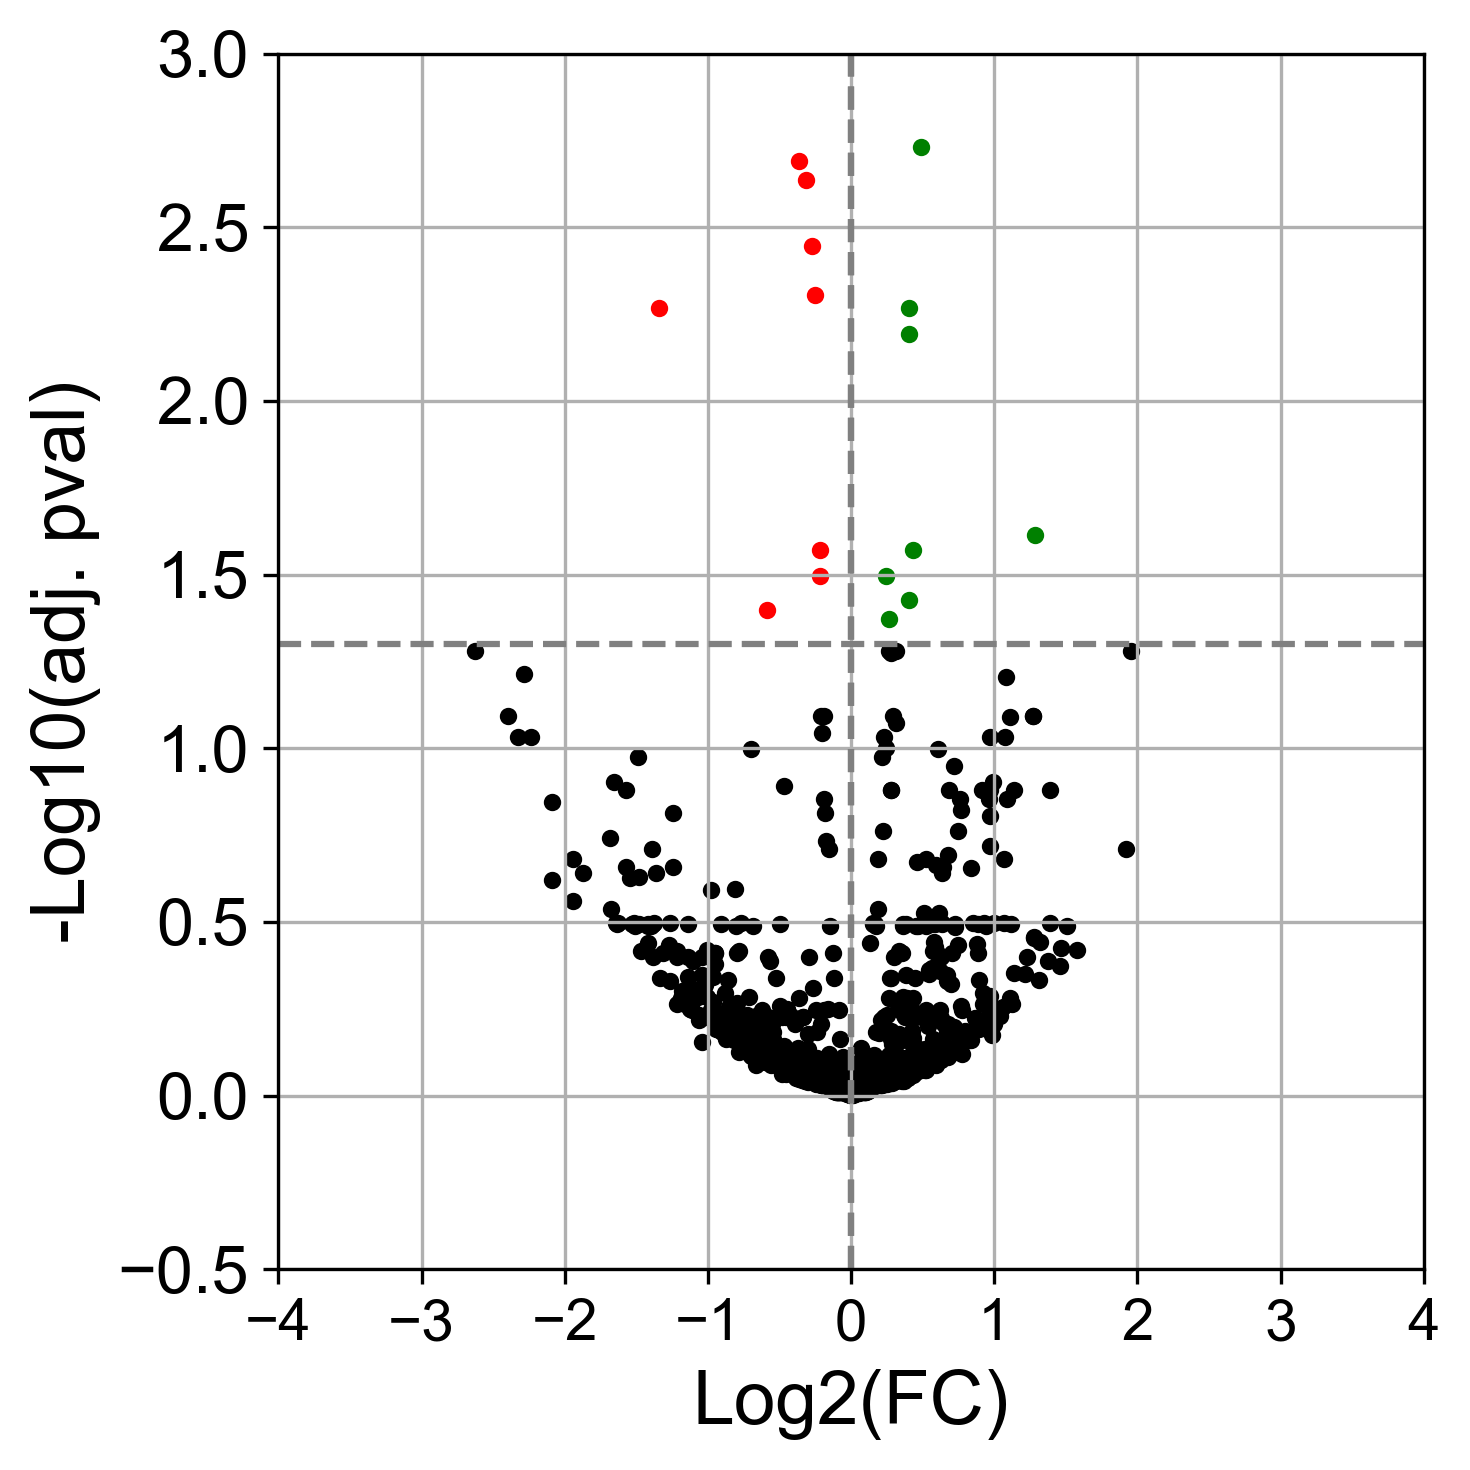

In [16]:
# valcano plot
df_dep['Y'] = -np.log10(df_dep['adj.P.Val'])
df_none = df_dep[df_dep['state'] == 'none']
df_up = df_dep[df_dep['state'] == 'up']
df_down = df_dep[df_dep['state'] == 'down']

plt.figure(figsize=(5, 5))
plt.scatter(x=df_none['logFC'],
            y=df_none['Y'],
            s=10, label="Not significant", color='black')
plt.scatter(x=df_down['logFC'],
            y=df_down['Y'],
            s=10, color="red")
plt.scatter(x=df_up['logFC'],
            y=df_up['Y'],
            s=10, color="green")

plt.axvline(cut_fc, color="grey", linestyle="--")
plt.axvline(-cut_fc, color="grey", linestyle="--")
plt.axhline(-np.log10(cut_p), color="grey", linestyle="--")

plt.ylabel("-Log10(adj. pval)", fontsize=18)
plt.xlabel("Log2(FC)", fontsize=18)
plt.xticks(fontweight='light', fontsize=14)
plt.yticks(fontweight='light', fontsize=16)
plt.grid(True)
plt.ylim(-0.5, 3)
plt.xlim(-4, 4)
# plt.xticks(np.arange(-1, 1.2, 0.5))
plt.tight_layout()
plt.show()

#### Pathway Analysis

In [17]:
# pg --> gene
protein_ids, gene_names, is_isoforms = [], [], []
with open(report_dir/'meta'/'swissprot_UP5640_human_20420_20240619.fasta', 'r') as fasta_file:
    for line in fasta_file:
        line = line.strip()
        if line.startswith(">"):
            protein_id = line.split('|')[1]
            gene_name = None
            for field in line.split():
                if field.startswith("GN="):
                    gene_name = field.split("=")[1]
                    break
            protein_ids.append(protein_id)
            gene_names.append(gene_name)
            is_isoforms.append(line.__contains__('isoform'))
df_map = pd.DataFrame({
    "protein": protein_ids, "gene": gene_names
})
df_map = df_map.dropna().reset_index(drop=True)
df_gene = pd.merge(df_dep, df_map, on='protein')
df_gene.copy()

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,state,Y,gene
0,P23284,-0.600634,15.595369,-8.820102,2.094503e-15,1.581350e-12,24.265663,down,11.800972,PPIB
1,Q9NTK5,-0.450650,13.861397,-6.615600,5.537642e-10,2.090460e-07,12.414540,down,6.679758,OLA1
2,P13639,-0.354885,15.560134,-5.847289,2.814307e-08,7.082671e-06,8.699869,down,5.149803,EEF2
3,Q05639,-0.338727,18.281778,-5.047221,1.229689e-06,2.321038e-04,5.146531,down,3.634318,EEF1A2
4,P62805,0.568816,19.193845,4.887843,2.500076e-06,3.775115e-04,4.482164,up,3.423070,H4C1
...,...,...,...,...,...,...,...,...,...,...
750,P13798,0.010369,9.242699,0.013548,9.892078e-01,9.944765e-01,-6.343804,none,0.002405,APEH
751,Q96C19,-0.005193,9.424887,-0.007594,9.939505e-01,9.978974e-01,-6.343865,none,0.000914,EFHD2
752,Q86V81,0.003031,11.196160,0.005958,9.952540e-01,9.978974e-01,-6.343876,none,0.000914,ALYREF
753,O15145,0.000636,13.734677,0.003377,9.973100e-01,9.979641e-01,-6.343888,none,0.000885,ARPC3


DNA Damage/Telomere Stress Induced Senescence


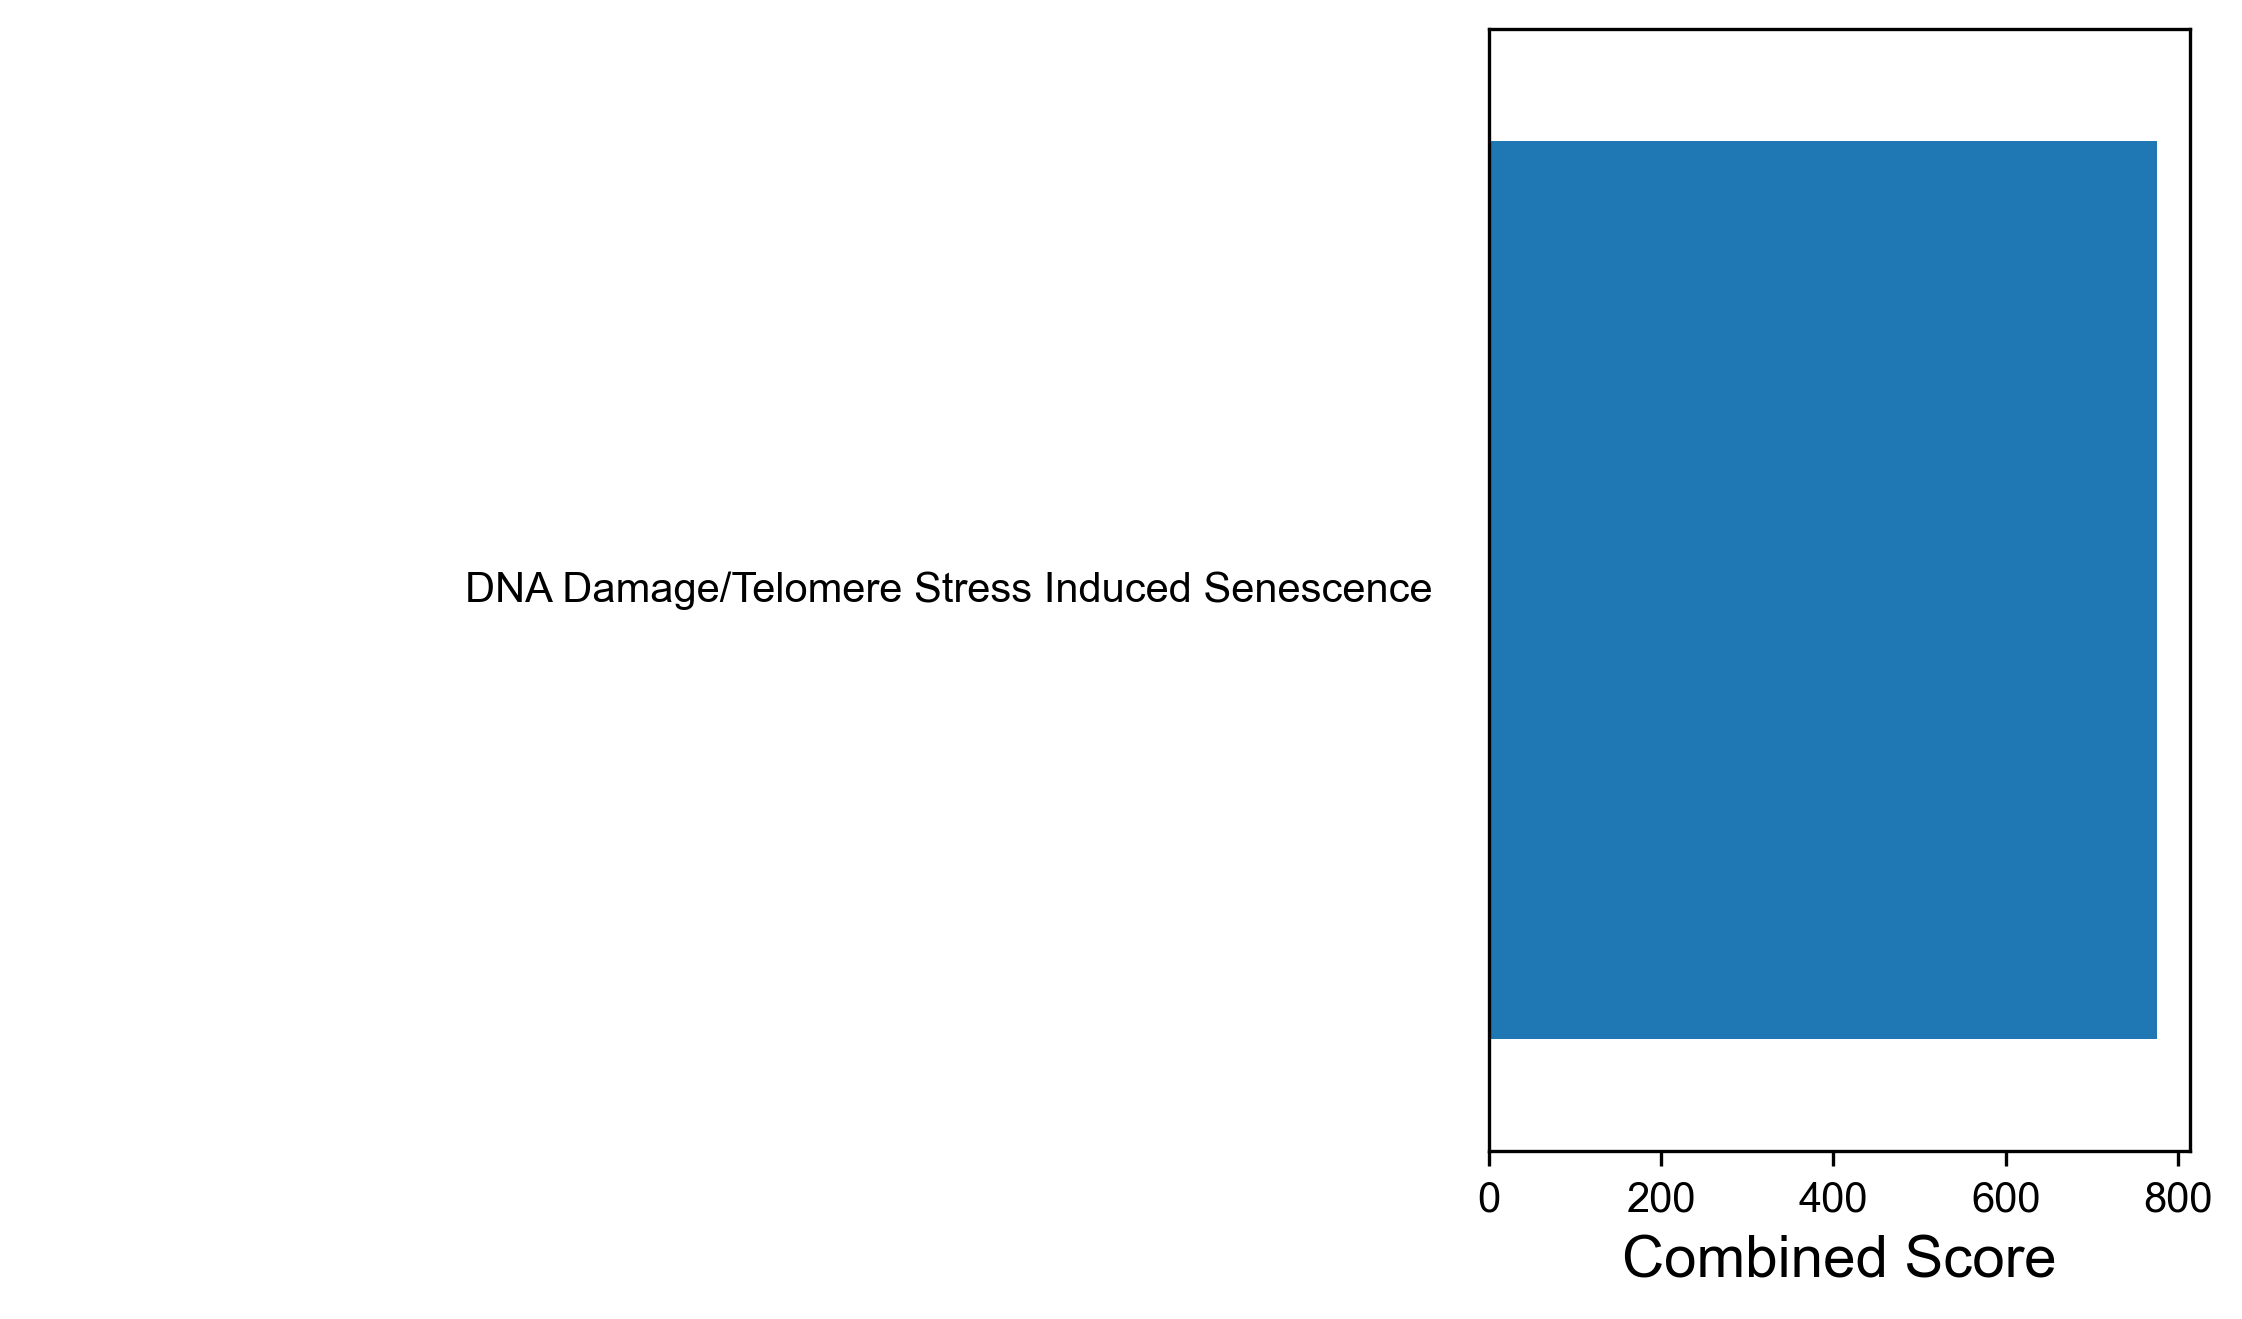

In [18]:
# up-pathway
import gseapy as gp
import matplotlib.gridspec as gridspec

n_path = 15

ups = set(df_gene[df_gene['state'] == 'up']['gene'])
enr = gp.enrichr(gene_list=list(ups),
                 gene_sets='Reactome_2022',
                 organism='Human',
                 outdir=None)
df_path = enr.results
df_path = df_path[df_path['Adjusted P-value'] < cut_p]
df_path = df_path.nlargest(n_path, 'Combined Score')

df_path['Term'] = df_path['Term'].str.split(' R-HSA-').str[0]
df_path = df_path.sort_values('Combined Score', ascending=True)
print(df_path['Term'][::-1].str.cat(sep=';'))

terms = df_path['Term'].astype(str).tolist()
scores = df_path['Combined Score'].tolist()
y_pos = np.arange(len(terms))

fig = plt.figure(figsize=(7.5, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# Left for terms
ax_text = plt.subplot(gs[0])
ax_text.set_xlim(0, 1)
ax_text.set_ylim(-0.5, len(terms) - 0.5)
ax_text.axis('off')
for i, term in enumerate(terms):
    ax_text.text(1.0, i, term, va='center', ha='right', fontsize=10)

# Right for scores
ax_bar = plt.subplot(gs[1])
ax_bar.barh(y_pos, scores)
ax_bar.set_yticks([])
ax_bar.set_ylim(-0.5, len(terms) - 0.5)
ax_bar.set_xlabel('Combined Score', fontsize=14)

plt.tight_layout()
plt.show()